In [1]:
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt

sys.path.append('/home/ubuntu/repos/learning-habits-analysis')
from utils.data import Subject, load_participant_list

from nilearn.image import concat_imgs
from nilearn import image
from nilearn.masking import apply_mask
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
base_dir = '/home/ubuntu/data/learning-habits'
first_lvl_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/mvpa_firststim_LSA_20250828'

In [3]:
run = 'learning1'

In [4]:
sub_ids = load_participant_list(base_dir)

In [5]:
dfs = [
  pd.read_csv(f"{first_lvl_dir}/sub-{sub_id}/run-{run}/sub-{sub_id}_run-{run}_trial_beta_mapping.csv")
  for sub_id in sub_ids
  if os.path.exists(f"{first_lvl_dir}/sub-{sub_id}/run-{run}/sub-{sub_id}_run-{run}_trial_beta_mapping.csv")
]
df = pd.concat(dfs, ignore_index=True)

In [6]:
df.head()

,sub_id,run,trial_index,onset,duration,first_stim,q_rl,q_ck,include_flag,beta_path,mode
0,sub-01,learning1,1,0.009399,0.817157,7,1.830729,0.000000,True,/home/ubuntu/data/learning-habits/bids_dataset...,LSA
1,sub-01,learning1,2,10.010661,0.884950,4,0.517113,0.000000,True,/home/ubuntu/data/learning-habits/bids_dataset...,LSA
2,sub-01,learning1,3,20.403639,0.965672,1,1.605469,0.000000,True,/home/ubuntu/data/learning-habits/bids_dataset...,LSA
3,sub-01,learning1,4,30.675264,0.803309,8,0.714286,0.000000,True,/home/ubuntu/data/learning-habits/bids_dataset...,LSA
4,sub-01,learning1,5,40.081664,0.912648,4,1.024152,0.006794,True,/home/ubuntu/data/learning-habits/bids_dataset...,LSA


# Mask

In [7]:
vmpfc_mask_path = '/home/ubuntu/data/learning-habits/masks/vmpfc_mask.nii.gz'

In [8]:
vmpfc_mask = image.load_img(vmpfc_mask_path)
sample_image = image.load_img(df.beta_path[0])
vmpfc_mask = image.resample_to_img(vmpfc_mask, sample_image, interpolation='nearest')
#vmpfc_masker = NiftiMasker(mask_img=vmpfc_mask)

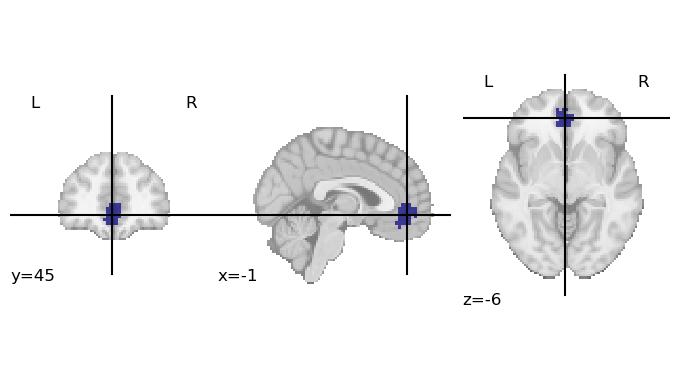

In [9]:
from nilearn.plotting import plot_roi
plot_roi(vmpfc_mask)

# Prepare X and y

In [10]:
imgs = [image.load_img(beta_path) for beta_path in df.beta_path]

In [11]:
X = apply_mask(imgs, vmpfc_mask)

In [12]:
df.columns

Index(['sub_id', 'run', 'trial_index', 'onset', 'duration', 'first_stim',
       'q_rl', 'q_ck', 'include_flag', 'beta_path', 'mode'],
      dtype='object')

In [13]:
y = df.q_rl
meta = df[['sub_id', 'run', 'trial_index', 'include_flag']]

In [14]:
assert len(X) == len(y)

In [15]:
from nilearn.decoding import DecoderRegressor
from sklearn.model_selection import LeaveOneGroupOut

In [17]:
dec = DecoderRegressor(
    estimator='ridge',           # ridge regression
    #cv=LeaveOneGroupOut(),       # LOSO by subject
    cv=5,
    screening_percentile=100,    # keep all 119 voxels
    standardize=True,            # z-score features inside CV folds
    scoring='r2',                # report R^2
    memory_level=2,
    n_jobs=-1
)

In [18]:
len(imgs)

5664

In [19]:
dec.fit(imgs[:500], y[:500])

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:249: UserWarning: Caching has been enabled (memory_level = 2) but no Memory object or path has been provided (parameter memory). Caching deactivated for function _parallel_fit.
  return cache(


In [26]:
dec.cv_scores_

{'beta': [-0.07715670388875373,
  -0.07650513027457206,
  -0.552341274177524,
  -0.11073720403464349,
  0.0120308334287893]}